In [339]:
import os

import numpy as np

from reproject import reproject_interp

from regions import CircleSkyRegion, RectangleSkyRegion

from astropy.io import fits
from astropy.wcs import WCS
import astropy.units as u
from astropy.coordinates import Angle, SkyCoord
from astropy.visualization.wcsaxes import add_scalebar

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm, SymLogNorm
import matplotlib.patheffects as pe

In [340]:
def plot():

    def rotate_wcs(wcs, angle):

        '''
        Rotates a WCS projection by some angle

        Parameters:

            wcs : astropy.wcs.wcs.WCS
                The original WCS projection

            angle : int
                The angle (in degrees) to rotate the WCS projection

        Returns:

            rotated_wcs : astropy.wcs.wcs.WCS
                The rotated WCS projection
        '''

        # Define the rotation angle
        angle = Angle(angle, unit='deg')

        # Get the CD matrix from the original WCS projection
        cd_matrix = wcs.wcs.cd

        # Calculate the rotation matrix
        cos_angle = np.cos(angle.rad)
        sin_angle = np.sin(angle.rad)
        rotation_matrix = np.array([[cos_angle, -sin_angle], [sin_angle, cos_angle]], dtype=np.float64)

        # Apply the rotation to the CD matrix
        rotated_cd_matrix = np.dot(cd_matrix, rotation_matrix)

        # Update the CD matrix in the rotated WCS projection
        rotated_wcs = wcs.deepcopy()
        rotated_wcs.wcs.cd = rotated_cd_matrix

        return rotated_wcs

    # Dictionary containing information of the images of the different source plane regions of the Sunburst Arc appearing in the zoom-in inset axes, including their coordinates 
    # (RA, declination), color, and label orientation. The image labels and colors follow the terminology and color scheme of Sharon et al. (2022) (ApJ, 941, 203)
    images = {
        '1.1': [237.530818, -78.182515, '#ff0000', 'left', 45], '1.2': [237.525561, -78.182754, '#ff0000', 'left', 60], '1.3': [237.524859, -78.182817, '#ff0000', 'right', 75],
        '1.4': [237.519097, -78.183181, '#ff0000', 'right', -45], '1.5': [237.518255, -78.183256, '#ff0000', 'right', 45], '1.6': [237.517455, -78.183354, '#ff0000', 'right', -45],
        '1.7': [237.509198, -78.184647, '#ff0000', 'left', -45], '1.8': [237.501508, -78.186259, '#ff0000', 'right', 45], '1.9': [237.499785, -78.186745, '#ff0000', 'right', 45],
        '1.10': [237.498917, -78.187077, '#ff0000', 'right', 45],

        '2.1': [237.528078, -78.182604, '#ff6f00', 'left', 45], '2.2': [237.527379, -78.182635, '#ff6f00', 'left', 45], '2.3': [237.523906, -78.182902, '#ff6f00', 'left', 45],
        '2.4': [237.520126, -78.183100, '#ff6f00', 'right', -45], '2.7': [237.508784, -78.184748, '#ff6f00', 'left', -45], '2.8': [237.503795, -78.185731, '#ff6f00', 'left', 45],

        '3.3': [237.523472, -78.182926, '#00eb00', 'right', 75], '3.4': [237.520701, -78.183058, '#00eb00', 'right', 75], '3.7': [237.508271, -78.184839, '#00eb00', 'right', 60],
        '3.8': [237.504896, -78.185501, '#00eb00', 'right', 60],

        '4.3': [237.523614, -78.182962, '#9C27B0', 'right', -45], '4.4': [237.520679, -78.183110, '#9C27B0', 'left', 45], '4.7': [237.509090, -78.184749, '#9C27B0', 'left', 30],
        '4.8': [237.5025603 - 0.0000547, -78.1861470 + 0.0000541, '#9C27B0', 'right', 75], '4.9': [237.499970, -78.186785, '#9C27B0', 'left', 45], '4.10': [237.499155, -78.187089, '#9C27B0', 'left', 45],

        '5.1': [237.530472, -78.182525, '#c62828', 'right', -45], '5.2': [237.525924, -78.182728, '#c62828', 'left', 45], '5.3': [237.524665, -78.182835, '#c62828', 'left', 60],
        '5.4': [237.519300, -78.183166, '#c62828', 'right', 75],

        '6.1': [237.530282, -78.182473, '#e53935', 'left', -45], '6.2': [237.526374, -78.182639, '#e53935', 'right', 45],

        '7.1': [237.529282, -78.182482, '#ef5350', 'right', 45], '7.2': [237.527034, -78.182569, '#ef5350', 'right', 45], '7.3': [237.523693, -78.182846, '#ef5350', 'left', -60],
        '7.4': [237.520049, -78.183013, '#ef5350', 'right', 45], '7.7': [237.507458, -78.184894, '#ef5350', 'right', 45], '7.8': [237.505953, -78.185193, '#ef5350', 'right', 45],

        '8.1': [237.528607, -78.182557, '#ef9a9a', 'left', 45], '8.2': [237.527136, -78.182623, '#ef9a9a', 'right', -45], '8.3': [237.523917, -78.182875, '#ef9a9a', 'left', -45],
        '8.4': [237.520032, -78.183080, '#ef9a9a', 'right', 30], '8.7': [237.508469, -78.184775, '#ef9a9a', 'left', -45], '8.8': [237.504388, -78.185573, '#ef9a9a', 'right', 60],

        '9.3': [237.523676, -78.182928, '#43a047', 'left', 60], '9.4': [237.520492, -78.183090, '#43a047', 'right', -45], '9.8': [237.504180, -78.185652, '#43a047', 'left', 45],

        '10.3': [237.523251, -78.182942, '#8bc34a', 'right', -45], '10.4': [237.521002, -78.183046, '#8bc34a', 'left', 45], '10.7': [237.508163, -78.184876, '#8bc34a', 'left', 60],
        '10.8': [237.505064, -78.185473, '#8bc34a', 'left', 45],

        '11.3': [237.523067, -78.182913, '#66bb6a', 'right', 45], '11.4': [237.521062, -78.182998, '#66bb6a', 'left', -45],

        '12.3': [237.522753, -78.182948, '#aed581', 'right', -45], '12.4': [237.521510, -78.182999, '#aed581', 'left', -45],

        '13.7': [237.507614, -78.185015, '#a5d6a7', 'right', 60], '13.8': [237.506255, -78.185277, '#a5d6a7', 'right', 45],

        '14.7': [237.507415, -78.185061, '#dcedc8', 'left', 75], '14.8': [237.506400, -78.185256, '#dcedc8', 'right', -60],

        '15.7': [237.507203, -78.185102, '#1b5e20', 'right', 45], '15.8': [237.506595, -78.185218, '#1b5e20', 'left', 45],

        '101.1': [237.532701, -78.182363, '#FF00FF', 'right', 0], '101.6': [237.517073, -78.183258, '#FF00FF', 'right', 0], '101.8': [237.503649, -78.185600, '#FF00FF', 'right', 15]
        }

    # Dictionary with information describing how to place label text 
    # around images based on a keyword
    image_label_positions = {
        'left': [-5, -5, 'right', 'center'],
        'right': [5, 5, 'left', 'center']
        }

    # Dictionary containing information about the position, orientation,
    # and style of the slit apertures
    slits = {
        'M5' : ['15:50:01.1649 -78:11:07.822', 0.85, 313, 'dashed'],
        'M4' : ['15:50:04.9279 -78:10:59.032', 0.85, 0, 'dashed'],
        'M6' : ['15:50:06.6389 -78:10:57.412', 0.85, 12, 'dashed'],
        'M3' : ['15:50:00.6009 -78:11:09.912', 0.85, 298, 'dashed'],
        'M0' : ['15:50:04.4759 -78:10:59.652', 1.0, 349, 'solid'],
        'M2' : ['15:49:59.7480 -78:11:13.482', 0.85, 52, 'solid'],
        'M7' : ['15:50:07.3959 -78:10:56.962', 0.85, 0, 'solid'],
        'M8' : ['15:49:59.9499 -78:11:12.242', 0.85, 330, 'solid'],
        'M9' : ['15:50:00.3719 -78:11:10.512', 0.85, 302, 'solid']
    }

    arc_labels = np.array(['N', 'NW'], dtype=str)
    filter_labels = np.array(['Lyα (F555W)', 'Lyα (F390W)', 'F275W'], dtype=str)

    # Establish common directories
    home = os.getcwd()
    data = f'{home}/data'
    figs = f'{home}/figs'
    results = f'{home}/results'

    hst_f275w_file = f'{data}/hst/V5.0_PSZ1G311.65-18.48_F275W_0.03g0.6_crsc1.2_0.7crsn3.5_3.0_drc_sci.fits'
    hst_f606w_file = f'{data}/hst/V5.0_PSZ1G311.65-18.48_F606W_0.03g0.6_crsc1.2_0.7crsn3.5_3.0_drc_sci.fits'
    lya_nb_f390w_file = f'{results}/Lya_cont_sub_F390W.fits'
    lya_nb_f555w_file = f'{results}/Lya_cont_sub_F555W.fits'

    files = np.array([lya_nb_f555w_file, lya_nb_f390w_file, hst_f275w_file], dtype=str)

    # Position, dimensions, and orientations of the boxes defining the areas of the inset, zoom-in axes, 
    # defined in pixel coordinates of the HST F606W observation's WCS projection
    center_n = (4591, 5303)
    center_nw = (5093, 4944)
    width, height = 464, 86
    angle_n = -19 
    angle_nw = -48 

    centers = [center_n, center_nw]
    angles = [-19, -48]

    # Get the WCS projection of the HST F606W observations
    hst_f606w_wcs = WCS(fits.getheader(hst_f606w_file))

    wcs_systems = []

    for i, angle in enumerate(angles):

        wcs_rotated = rotate_wcs(hst_f606w_wcs, angle)

        wcs_systems = np.append(wcs_systems, wcs_rotated)

    fig, ax = plt.subplots(6,1, figsize=(10,10*516/464))#, constrained_layout=True)
    #fig.tight_layout()

    for i, file in enumerate(files):

        data = fits.getdata(file)

        #wcs = WCS(fits.getheader(file))

        for j, axes in enumerate([ax[0 + i], ax[3 + i]]):

            #wcs_rotated = rotate_wcs(wcs, angles[j])

            #print(repr(wcs_rotated))

            data_rotated, _ = reproject_interp((data, hst_f606w_wcs), wcs_systems[j], (6000,6000))

            axes = plt.subplot(611 + 3 * j + i, projection=wcs_systems[j])

            vmin = -0.01 if i == 2 else -0.1
            vmax = 0.01 if i == 2 else 0.1

            axes.imshow(data_rotated, origin='lower', cmap='coolwarm', norm=SymLogNorm(vmin=-0.1, vmax=0.1, linthresh=0.0001, linscale=0.0001, base=10), #vmin=0.001 * abs(np.nanmedian(data_rotated)), vmax=10 * abs(np.nanmedian(data_rotated)), #norm=LogNorm(vmin=0.001 * np.abs(np.nanmedian(data_rotated)), vmax=10 * np.abs(np.nanmedian(data_rotated))), 
                interpolation='none')

            center = wcs_systems[j].world_to_pixel_values([hst_f606w_wcs.pixel_to_world_values([[*centers[j]]])[0]])[0]

            axes.set_xlim(center[0] - width/2, center[0] + width/2)
            axes.set_ylim(center[1] - height/2, center[1] + height/2)

            for k, coord_ax in enumerate([*axes.coords]):

                # Disable the ticks, tick labels, and axis label of the cordinate axis
                coord_ax.set_ticks_visible(False)
                coord_ax.set_ticklabel_visible(False)
                coord_ax.set_axislabel('')

            arc_label = axes.annotate(arc_labels[j], xy=(0.01, 1 - 0.01 * 464 / 86), xycoords='axes fraction', ha='left', va='top', fontsize=10, fontweight='bold')

            filter_label = axes.annotate(filter_labels[i], xy=(0.99, 1 - 0.01 * 464 / 86), xycoords='axes fraction', ha='right', va='top', fontsize=10, fontweight='bold')

            # Add an outline around the labels to make them easier to read
            arc_label.set_path_effects([pe.withStroke(linewidth=1, foreground='white')])
            filter_label.set_path_effects([pe.withStroke(linewidth=1, foreground='white')])

            add_scalebar(axes, 1 * u.arcsecond, label='1\'\'', corner='bottom left')#, fontsize=4)

            # For each slit aperture ID
            for k, slit_id in enumerate(slits):

                # Instantiate the slit as a RectangleSkyRegion
                slit_region = RectangleSkyRegion(center=SkyCoord(slits[slit_id][0], unit=(u.hourangle, u.deg), frame='fk5'), 
                    width=slits[slit_id][1] * u.arcsecond, height=10 * u.arcsecond, angle=slits[slit_id][2] * u.deg)

                # Convert the slit region object to a pixel-based representation
                slit_region_pxl = slit_region.to_pixel(wcs_systems[j])
    
                # Plot the slit region on the axes
                slit_region_pxl.plot(ax=axes, color='#D41159', lw=1, linestyle=slits[slit_id][3])

            # For each tuple of axes and associated WCS
            for k, image in enumerate(images):

                # Get the color used for the region in the lens model from Sharon+2022 (ApJ, 941, 203)
                color = images[image][2]

                # Get the position keyword used to orient the label text
                loc = images[image][3]

                # Get the angle to orient the text around the image
                angle = images[image][4]

                # The radius (half width) of the circle (square) around an image. Image 4.8 requires a larger radius
                # because it is a series of images of unclear, but similar relation
                radius = 0.4 * u.arcsecond if image == '4.8' else 0.1 * u.arcsecond

                # Pixel coordinates of a manual offset for all label text. This is necessary because the astrometry 
                # used for the presented image coordinates in Sharon et al. (2022) (ApJ, 941, 203) appears to be less 
                # accurate than available with the current data reduction
                offset = [1.1, 1.0]

                # Instantiate a circular region. The manual coordinate offset from the listed dictionary value is necessary because of the astrometry difference mentioned above
                image_region = RectangleSkyRegion(center=SkyCoord(images[image][0] + 0.0000547, images[image][1] - 0.0000541, unit='deg', frame='fk5'), width=2 * radius, height=2 * radius, angle=angles[j] * u.deg) if image[:2] == '1.' \
                    else CircleSkyRegion(center=SkyCoord(images[image][0] + 0.0000547, images[image][1] - 0.0000541, unit='deg', frame='fk5'), radius=radius)

                # Conver the slit region object to a pixel-based representation
                image_region_pxl = image_region.to_pixel(wcs_systems[j])
    
                # Plot the slit region on the main image
                image_region_pxl.plot(ax=axes, color=color, lw=1.0)

                # Get the pixel coordinates of the image using the same manual coordinate offset mentioned previously
                image_pxl_coords = wcs_systems[j].world_to_pixel_values([[images[image][0] + 0.0000547, images[image][1] - 0.0000541]])
                image_pxl_coords = np.array([image_pxl_coords[0][0], image_pxl_coords[0][1]])# + np.array([dict[loc][0], dict[loc][1]], dtype=float)# - np.array([points[j][1], points[j][0]], dtype=float)

                # The radius of the text label in pixel coordinates from the coordinate center of the image
                radius_text = [16,16] if image == '4.8' else image_label_positions[loc]

                radius_text = [radius_text[0], radius_text[1]] + np.sign([radius_text[0], radius_text[1]]) if image[:2] == '1.' else radius_text

                # Calculate the position of the annotation in pixel coordinates
                xytext = (image_pxl_coords[0] + radius_text[0] * np.cos(np.radians(angle)),
                    image_pxl_coords[1] - offset[j] + radius_text[1] * np.sin(np.radians(angle)))

                # Annotate the image with a label
                label = axes.annotate(image.upper(), xy=xytext, rotation=angle, rotation_mode='anchor', 
                    ha=image_label_positions[loc][2], va=image_label_positions[loc][3], color=color, fontsize='small')

                # Add an outline around the labels to make them easier to read
                label.set_path_effects([pe.withStroke(linewidth=1, foreground='black')])

    fig.savefig(f'{figs}/lya_and_lyc_maps.pdf', bbox_inches='tight')

C:\Users\15136\AppData\Local\Temp/ipykernel_17428/3185606764.py:164: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  axes = plt.subplot(611 + 3 * j + i, projection=wcs_systems[j])
c:\Users\15136\AppData\Local\Programs\Python\Python39\lib\site-packages\regions\shapes\rectangle.py:201: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  return Rectangle(xy=xy, width=width, height=height,
c:\Users\15136\AppData\Local\Programs\Python\Python39\lib\site-packages\regions\shapes\circle.py:161: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  return Circle(xy=xy, radius=radius, **mpl_kwargs)


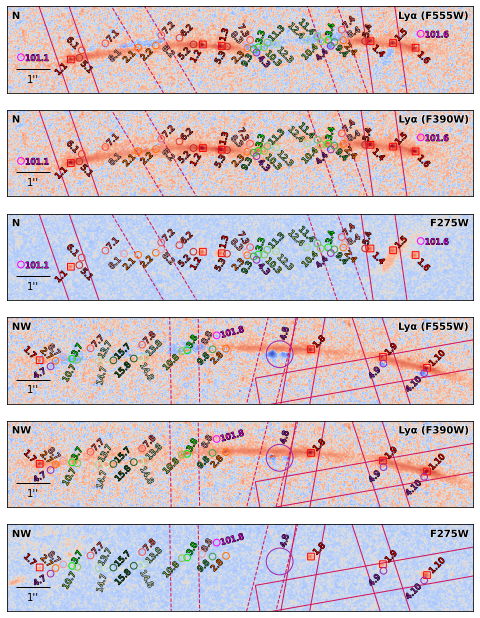

In [341]:
plot()